In [1]:
# Create a app for the mental Health Prediction by using the supervised learning (Random Forest classifier) and the Neural Networking

In [2]:
# Load the libaries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
#models directory exists

os.makedirs("models", exist_ok=True)

In [4]:
# Load dataset

df = pd.read_csv("mental_health_dataset.csv")

print("Initial Shape:", df.shape)
df.head()

Initial Shape: (10000, 14)


,age,gender,employment_status,work_environment,mental_health_history,seeks_treatment,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,mental_health_risk
0,56,Male,Employed,On-site,Yes,Yes,6,6.2,3,28,17,54,59.7,High
1,46,Female,Student,On-site,No,Yes,10,9.0,4,30,11,85,54.9,High
2,32,Female,Employed,On-site,Yes,No,7,7.7,2,24,7,62,61.3,Medium
3,60,Non-binary,Self-employed,On-site,No,No,4,4.5,4,6,0,95,97.0,Low
4,25,Female,Self-employed,On-site,Yes,Yes,3,5.4,0,24,12,70,69.0,High


In [5]:
# Processing the EDA on the Dataset

In [6]:
# 1. NULL VALUE CHECK

df.isna().sum(axis=0)

age                       0
gender                    0
employment_status         0
work_environment          0
mental_health_history     0
seeks_treatment           0
stress_level              0
sleep_hours               0
physical_activity_days    0
depression_score          0
anxiety_score             0
social_support_score      0
productivity_score        0
mental_health_risk        0
dtype: int64

In [7]:
# Drop rows with any nulls (or you can use imputation)

df.dropna(inplace=True)
print("After Dropping Nulls:", df.shape)

After Dropping Nulls: (10000, 14)


In [8]:
# 2. CLEAN GENDER COLUMN

df["gender"].unique()

array(['Male', 'Female', 'Non-binary', 'Prefer not to say'], dtype=object)

In [9]:
df["gender"].value_counts()

gender
Male                 4557
Female               4457
Non-binary            520
Prefer not to say     466
Name: count, dtype: int64

In [10]:
# Normalize gender values
df['gender'] = df['gender'].str.lower().str.strip()
df['gender'] = df['gender'].replace({
    'm': 'male', 'mail': 'male',
    'f': 'female', 'femlae': 'female', 'femal': 'female',
    'non binary': 'non-binary', 'trans': 'non-binary'
})

In [11]:
# Filter valid gender values only
valid_genders = ['male', 'female', 'non-binary']
df = df[df['gender'].isin(valid_genders)]
print(" Cleaned Gender Values:", df['gender'].unique())

 Cleaned Gender Values: ['male' 'female' 'non-binary']


In [12]:
# 3. VALIDATE AGE RANGE

print("Age Summary:\n", df['age'].describe())

Age Summary:
 count    9534.000000
mean       41.535872
std        13.744561
min        18.000000
25%        30.000000
50%        41.500000
75%        53.000000
max        65.000000
Name: age, dtype: float64


In [13]:
# Remove unrealistic ages
df = df[(df['age'] >= 10) & (df['age'] <= 100)]

In [14]:
# 4. OUTLIER DETECTION & REMOVAL

def remove_outliers_iqr(dataframe, col):
    Q1 = dataframe[col].quantile(0.25)
    Q3 = dataframe[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return dataframe[(dataframe[col] >= lower) & (dataframe[col] <= upper)]

In [15]:
# Apply to all numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    df = remove_outliers_iqr(df, col)

In [16]:
print("Final Cleaned Data Summary:\n", df.describe())
print("Final Shape after EDA:", df.shape)

Final Cleaned Data Summary:
                age  stress_level  sleep_hours  physical_activity_days  \
count  9534.000000   9534.000000  9534.000000             9534.000000   
mean     41.535872      5.569436     6.467915                3.503356   
std      13.744561      2.881912     1.473020                2.281864   
min      18.000000      1.000000     3.000000                0.000000   
25%      30.000000      3.000000     5.500000                2.000000   
50%      41.500000      6.000000     6.500000                4.000000   
75%      53.000000      8.000000     7.500000                5.000000   
max      65.000000     10.000000    10.000000                7.000000   

       depression_score  anxiety_score  social_support_score  \
count       9534.000000    9534.000000           9534.000000   
mean          15.053073      10.548039             50.224670   
std            8.983295       6.333054             29.227623   
min            0.000000       0.000000              0.000

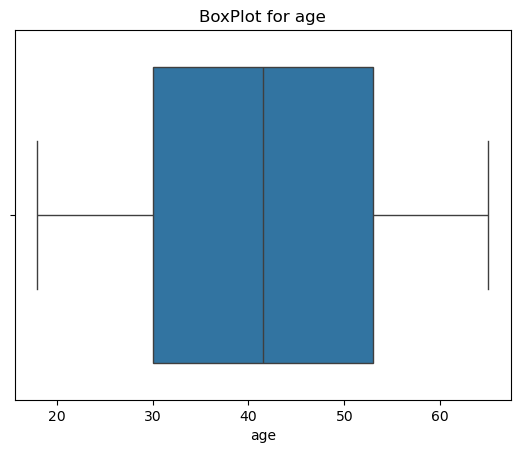

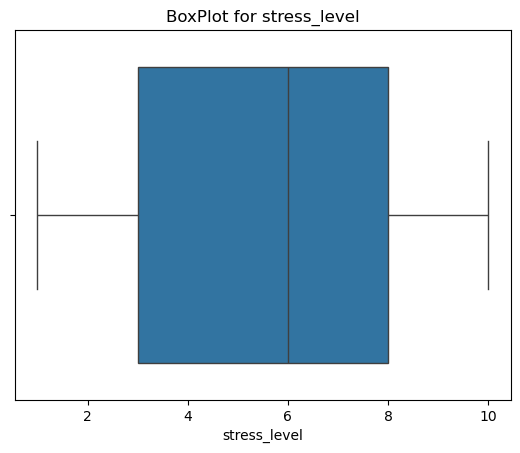

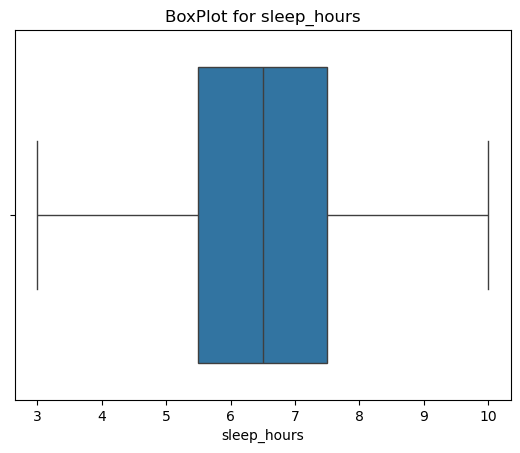

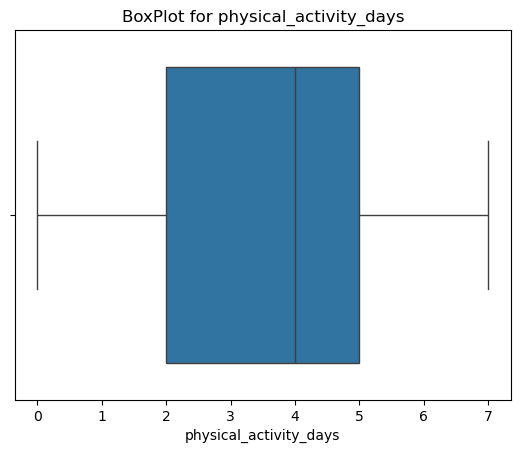

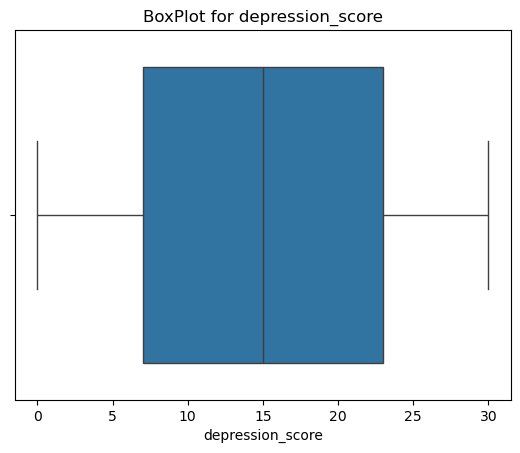

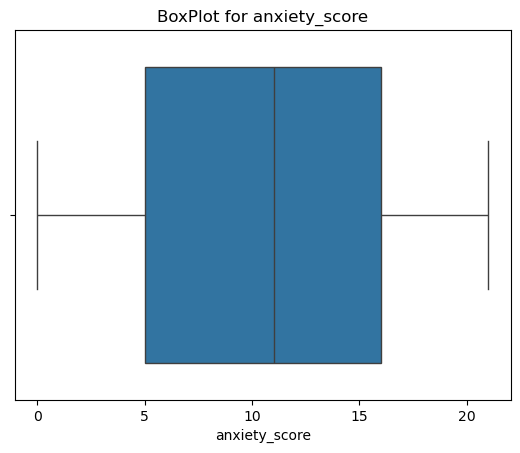

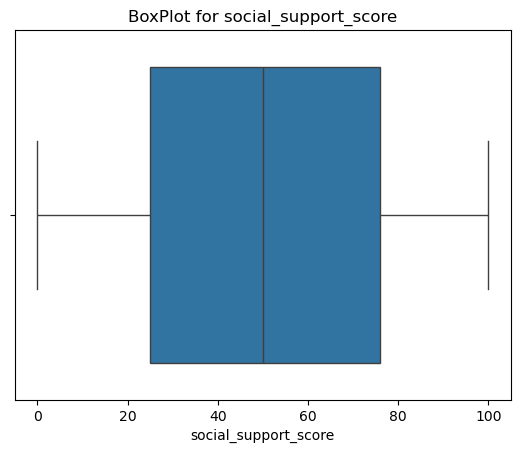

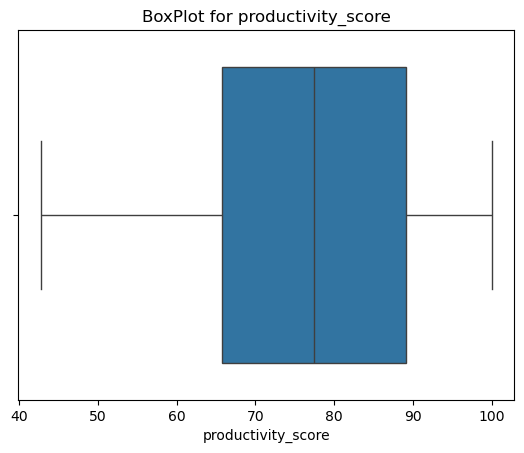

In [17]:
# 5 VISUALIZATION of EDA
for col in num_cols:
  sns.boxplot(data = df, x = col)
  plt.title(f"BoxPlot for {col}")
  plt.show()

In [18]:
# Pre-Processing of Dataset

In [19]:
# 1. Separate Features & Target

target_col = 'mental_health_risk'
X = df.drop(columns=[target_col])
y = df[target_col]

In [20]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [21]:
# 2. Encode Target Labels (Low, Medium, High → 0, 1, 2)

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# Assuming you have your preprocessed DataFrame 'df' or the individual series of categorical data
# Example data (replace with your actual data loading and preprocessing steps)
data = {
    'gender': ['Male', 'Female', 'Non-binary', 'Male', 'Female'],
    'employment_status': ['Employed', 'Student', 'Employed', 'Unemployed', 'Student'],
    'work_environment': ['On-site', 'Remote', 'Hybrid', 'On-site', 'Remote'],
    'mental_health_history': ['No', 'Yes', 'No', 'Yes', 'No'],
    'seeks_treatment': ['No', 'Yes', 'No', 'No', 'Yes'],
    'mental_health_risk': ['Low', 'Medium', 'Low', 'High', 'Medium'] # Your target variable
}
df = pd.DataFrame(data)

# Dictionary to hold all label encoders
label_encoders = {}

# List of categorical features from your dataset that need encoding
categorical_features_for_input = [
    'gender', 'employment_status', 'work_environment',
    'mental_health_history', 'seeks_treatment'
]
target_feature = 'mental_health_risk' # Your target variable

# Fit and store LabelEncoders for input features
for feature in categorical_features_for_input:
    le = LabelEncoder()
    # Ensure you fit on the entire column of your training data
    label_encoders[feature] = le.fit(df[feature]) # Use your actual training data's column

# Fit and store LabelEncoder for the target variable (mental_health_risk)
le_risk = LabelEncoder()
label_encoders[target_feature] = le_risk.fit(df[target_feature]) # Use your actual training data's target column

# Create the models directory if it doesn't exist
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

# Save the dictionary of label encoders
joblib.dump(label_encoders, os.path.join(models_dir, 'label_encoder.pkl'))

print("All label encoders saved successfully as a dictionary in models/label_encoder.pkl")


All label encoders saved successfully as a dictionary in models/label_encoder.pkl


In [22]:
# 3. Identify Categorical and Numerical Columns

categorical_cols = ['gender', 'employment_status', 'work_environment', 'mental_health_history', 'seeks_treatment']
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in categorical_cols]

In [23]:
# 4. One-Hot Encode Categorical Features

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [24]:
# 5. Feature Scaling (StandardScaler)

scaler = StandardScaler()
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

joblib.dump(scaler, "models/scaler.pkl")

['models/scaler.pkl']

In [25]:
X_encoded.head()

,age,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,gender_male,gender_non-binary,employment_status_Self-employed,employment_status_Student,employment_status_Unemployed,work_environment_On-site,work_environment_Remote,mental_health_history_Yes,seeks_treatment_Yes
0,1.052408,0.14941,-0.181891,-0.220602,1.441298,1.018829,0.129177,-1.252426,True,False,False,False,False,True,False,True,True
1,0.324809,1.53745,1.719066,0.217660,1.663945,0.071369,1.189873,-1.594044,False,False,False,True,False,True,False,False,True
2,-0.693829,0.49642,0.836479,-0.658863,0.996004,-0.560271,0.402905,-1.138553,False,False,False,False,False,True,False,True,False
3,1.343448,-0.54461,-1.336043,0.217660,-1.007820,-1.665641,1.532033,1.402231,False,True,True,False,False,True,False,False,False
4,-1.203148,-0.89162,-0.725022,-1.535385,0.996004,0.229279,0.676633,-0.590541,False,False,True,False,False,True,False,True,True


In [26]:
# 6. Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [27]:
#................................. RANDOM FOREST MODEL........................................

print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

joblib.dump(rf_model, "models/rf_model.pkl")
y_pred_rf = rf_model.predict(X_test)
print(" Random Forest Report:\n", classification_report(y_test, y_pred_rf))

Training Random Forest...
 Random Forest Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       451
           1       0.99      0.94      0.96       332
           2       0.98      0.99      0.98      1124

    accuracy                           0.98      1907
   macro avg       0.98      0.97      0.98      1907
weighted avg       0.98      0.98      0.98      1907



In [28]:
# 4. NEURAL NETWORK MODEL

print("Training Neural Network...")
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

Training Neural Network...


f:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
#Compile the model

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
early_stop = EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=5,                   # Wait 5 epochs without improvement before stopping
    restore_best_weights=True    # Restore the best weights after stopping
)

In [31]:
history = nn_model.fit(X_train, y_train_cat,validation_split=0.2,epochs=30,batch_size=32,callbacks=[early_stop],verbose=1)

Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6324 - loss: 0.8251 - val_accuracy: 0.9050 - val_loss: 0.3274
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8381 - loss: 0.3805 - val_accuracy: 0.9089 - val_loss: 0.2194
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8782 - loss: 0.2961 - val_accuracy: 0.9286 - val_loss: 0.1773
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8931 - loss: 0.2558 - val_accuracy: 0.9384 - val_loss: 0.1571
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9061 - loss: 0.2194 - val_accuracy: 0.9377 - val_loss: 0.1485
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9108 - loss: 0.1960 - val_accuracy: 0.9397 - val_loss: 0.1390
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9275 - loss: 0.1756 - val_accuracy: 0.9495 - val_loss: 0.1232
Epoch 8/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9316 - loss: 0.1595 - val_accuracy: 0.

In [32]:
nn_model.save("models/nn_model.h5")

In [33]:
nn_model.evaluate(X_test, y_test_cat)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9908 - loss: 0.0346


[0.031809888780117035, 0.9905610680580139]

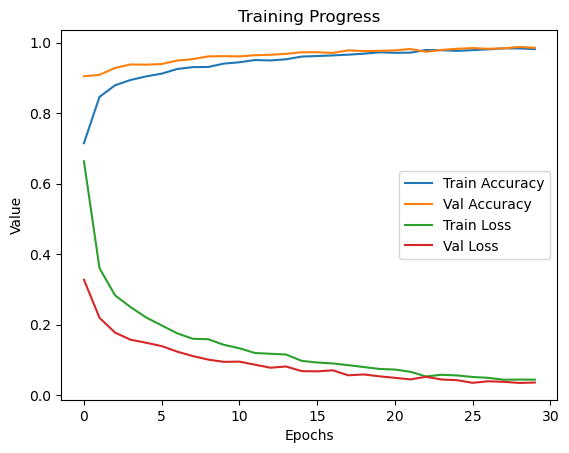

In [34]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training Progress")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()